## Sample Analysis

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

# with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
#     sample_data1 = pickle.load(file)
# print(sample_data1.keys())

# with open('/srv/scratch/z5297792/Sample/500plus_sample_data.pkl', 'rb') as file:
#     sample_data2 = pickle.load(file)
# print(sample_data2.keys())

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)


['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d


fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

eddy = 'Eddy22' # AE no-tilt # good \
eddy = 'Eddy110' # AE tilt # good off my own analysis \
eddy = 'Eddy134' # CE non-tilt # best \
eddy = 'Eddy133' # CE tilt \
\
eddy = 'Eddy790' # AE non-tilt # best \
eddy = 'Eddy761' # CE non-tilt # not bad \
eddy = 'Eddy749' # CE tilt # good \
eddy = 'Eddy775' # CE tilt # best \
\
The Sample Frontiers: \
\
AE790 no-tilt \
AE110 tilt \
CE134 no-tilt \
CE775 tilt 




## The Frontiers

In [3]:
# cap everything at COWs depth
d_dic = {}
for eddy in the_frontier_eddies:
    d_df = pd.DataFrame()
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]
    d_dic[eddy] = d_df


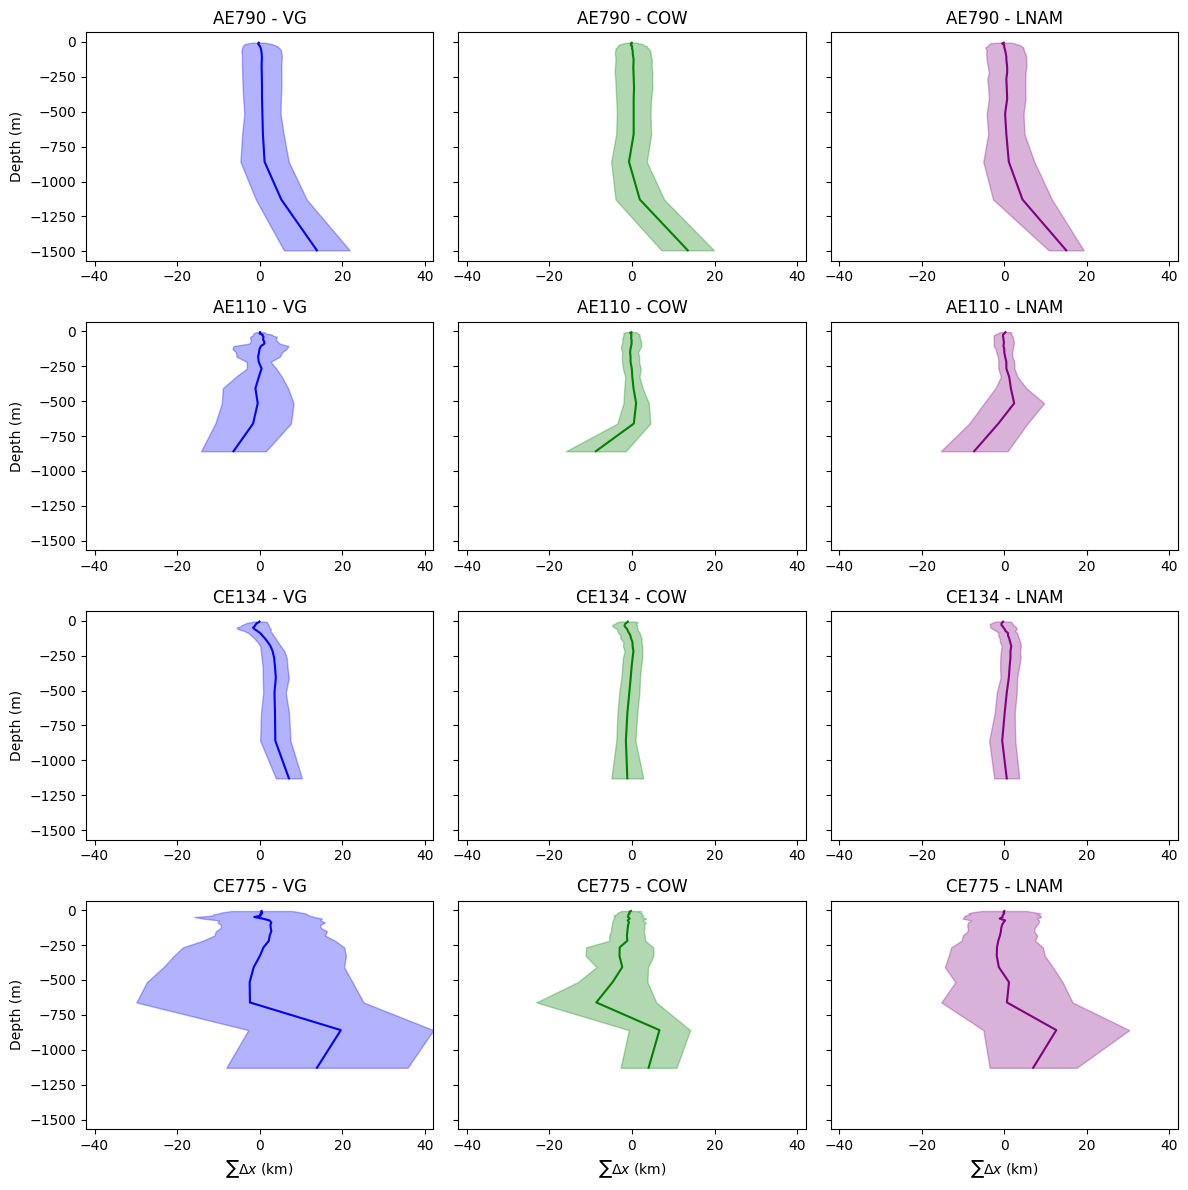

In [4]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        x_df = pd.DataFrame({f'T{t}': frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x'] for t in range(30)})
        x_mean, x_std = x_df.diff().cumsum().mean(axis=1)/1000, x_df.diff().cumsum().std(axis=1)/1000
        ax.plot(x_mean, z_r[150, 150, :len(x_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(x_mean)], x_mean - x_std, x_mean + x_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta x$ (km)")

        xmin = min(np.nanmin(x_mean - x_std), xmin)
        xmax = max(np.nanmax(x_mean + x_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

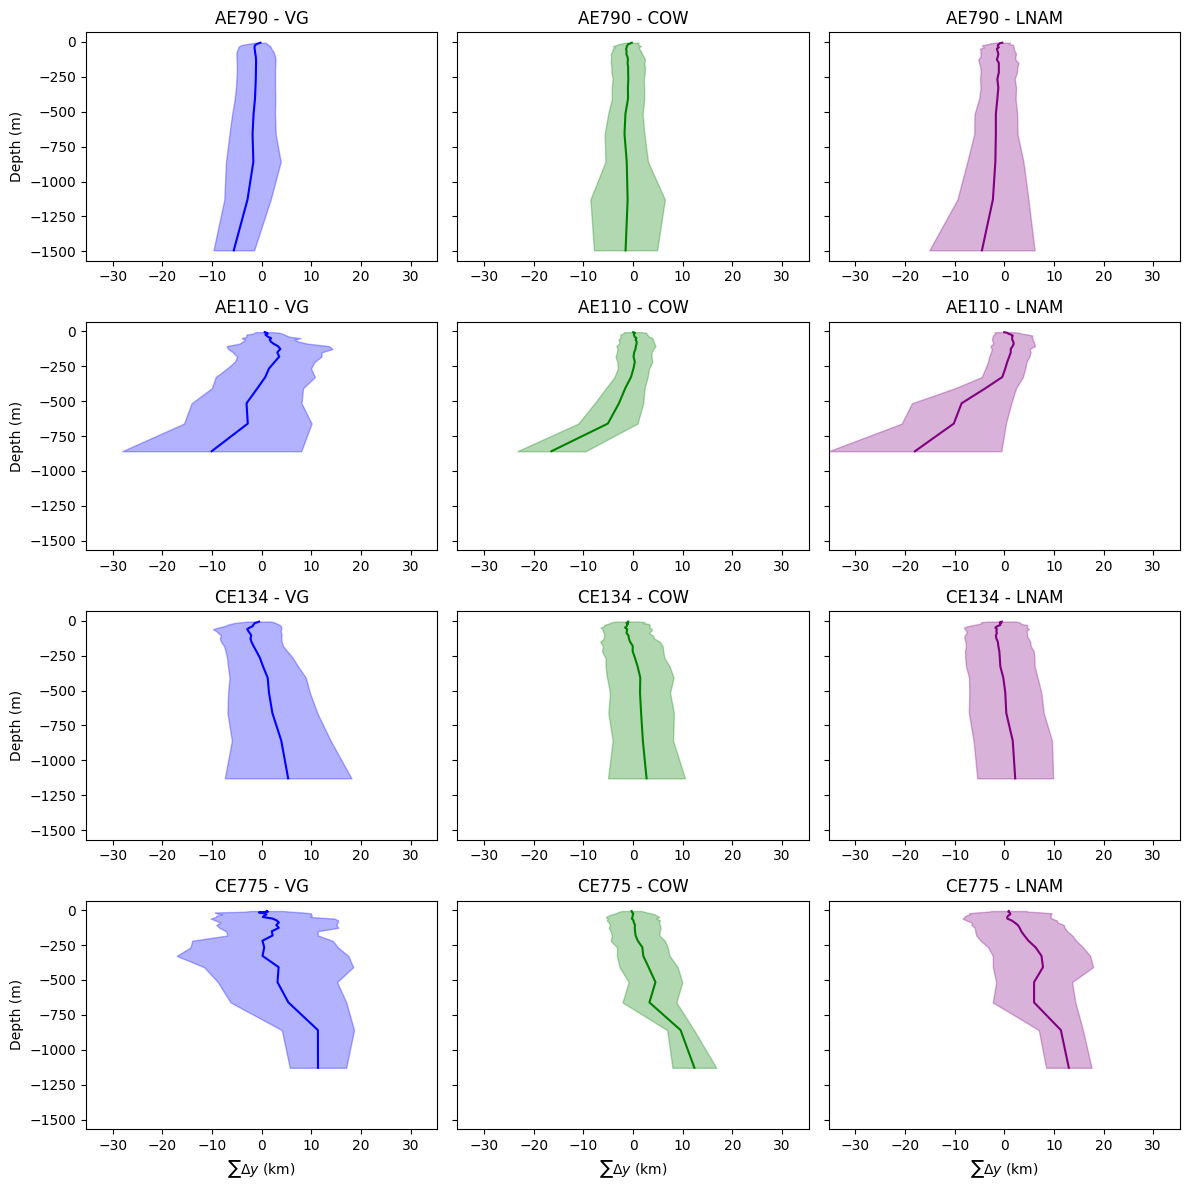

In [5]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        y_df = pd.DataFrame({f'T{t}': frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y'] for t in range(30)})
        y_mean, y_std = y_df.diff().cumsum().mean(axis=1)/1000, y_df.diff().cumsum().std(axis=1)/1000
        ax.plot(y_mean, z_r[150, 150, :len(y_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(y_mean)], y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\Delta y$ (km)")

        xmin = min(np.nanmin(y_mean - y_std), xmin)
        xmax = max(np.nanmax(y_mean + y_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

## Covariance Analysis

In [6]:
def normalize_list(input_list):
    total_sum = sum(input_list)
    if total_sum == 0:
        return np.zeros(len(input_list))
    normalized_arr = np.array(input_list) / total_sum
    return normalized_arr / normalized_arr.sum()

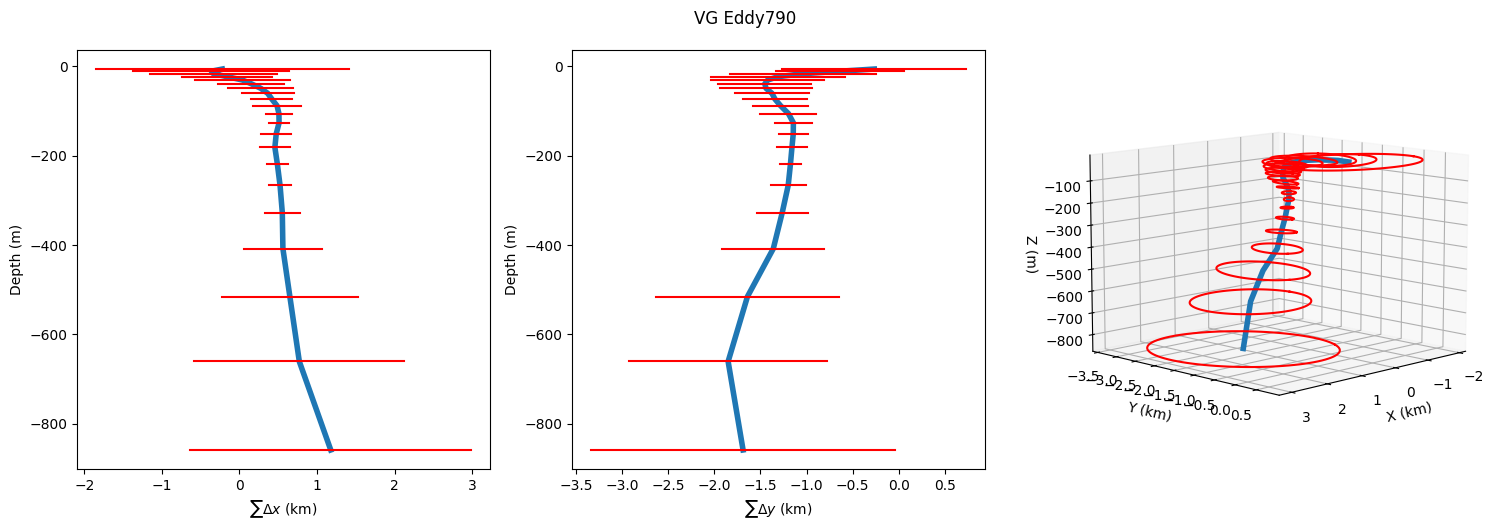

In [7]:
# choose eddy
eddy = the_frontier_eddies[0]

method = 'VG'

# create x and y dataframes 
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_df['T'+str(t)] = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
    y_df['T'+str(t)] = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
# calcualte covariance matrices
Cz = np.full((2, 2, x_df.shape[0]), np.nan)
for k in range(1, x_df.shape[0]):
    x = x_df.diff().iloc[k]
    x = x.loc[~np.isnan(x)]
    y = y_df.diff().iloc[k]
    y = y.loc[~np.isnan(y)]
    Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
# plot 
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()
fig = plt.figure(figsize=(15, 5))
ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133, projection='3d')]
ax[0].plot(x, z_r[150, 150, :len(x)], linewidth=4)
ax[1].plot(y, z_r[150, 150, :len(x)], linewidth=4)
ax[2].plot(x, y, z_r[150, 150, :len(x)], linewidth=4)
for k in range(len(x)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    ax[0].plot([np.min(ellipse_points[0, :] + x[k]), np.max(ellipse_points[0, :] + x[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[1].plot([np.min(ellipse_points[1, :] + y[k]), np.max(ellipse_points[1, :] + y[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[2].plot(ellipse_points[0, :] + x[k], ellipse_points[1, :] + y[k], [z_r[150, 150, k]] * len(ellipse_points[0, :]), color='r')

ax[2].view_init(elev=10, azim=45)
ax[0].set_xlabel(r'$\sum\Delta x$ (km)')
ax[1].set_xlabel(r'$\sum\Delta y$ (km)')
ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_zlabel('Z (m)')
plt.tight_layout()
plt.suptitle(method + ' ' + eddy, y=1.05)
plt.show()



77.21179496768895
89.29121144141557
145.43392209160234


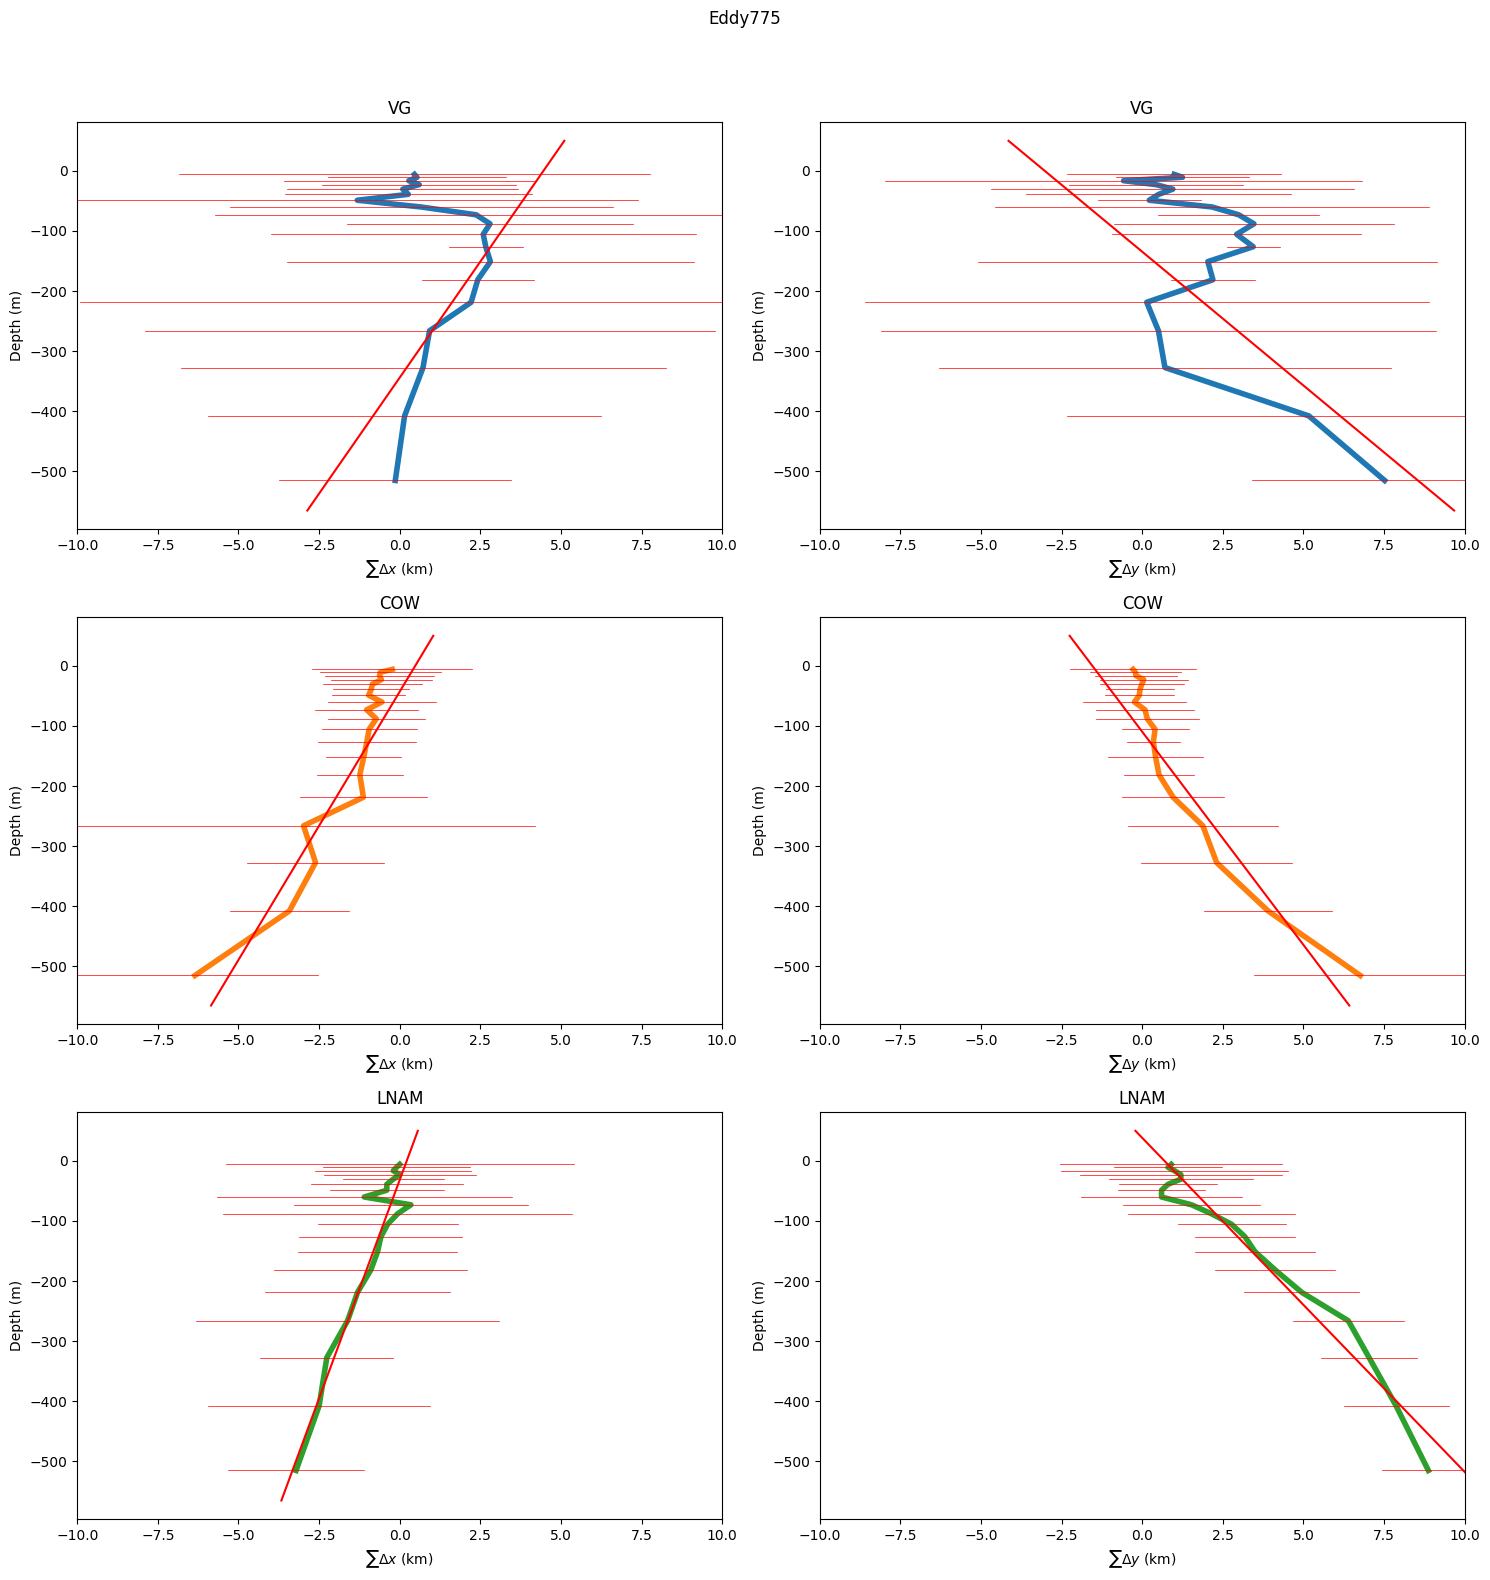

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid of subplots

eddy = the_frontier_eddies[3]

xmax = 10
xmin = -xmax

colors = plt.cm.tab10.colors
slopes_x, slopes_y = [], []
for row, method in enumerate(['VG', 'COW', 'LNAM']):
    # create x and y dataframes 
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_df['T'+str(t)] = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
        y_df['T'+str(t)] = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
    # Calculate covariance matrices
    Cz = np.full((2, 2, x_df.shape[0]), np.nan)
    for k in range(1, x_df.shape[0]):
        x = x_df.diff().iloc[k]
        x = x.loc[~np.isnan(x)]
        y = y_df.diff().iloc[k]
        y = y.loc[~np.isnan(y)]
        Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
    # Plot 
    x = x_df.diff().mean(axis=1).cumsum()
    y = y_df.diff().mean(axis=1).cumsum()
    # Select the row for each method in the 3x2 plot
    ax_x = axes[row, 0]  # X plot
    ax_y = axes[row, 1]  # Y plot
    
    ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    
    # ellipse_areas = []
    x_error = []
    y_error = []
    for k in range(len(x)):
        C = Cz[:, :, k]
        eigvals, eigvecs = np.linalg.eigh(C)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        axis_lengths = np.sqrt(eigvals)
        # ellipse_areas.append(np.pi * axis_lengths[0] * axis_lengths[1]) 
        t = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        ellipse_points = rotation_matrix.dot(ellipse_points)
        x_error.append(np.max(ellipse_points[0, :]) - np.min(ellipse_points[0, :]))
        y_error.append(np.max(ellipse_points[1, :]) - np.min(ellipse_points[1, :]))
        # Plot ellipses on the respective axes
        ax_x.plot([np.min(ellipse_points[0, :] + x[k]), np.max(ellipse_points[0, :] + x[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r', linewidth=.5)
        ax_y.plot([np.min(ellipse_points[1, :] + y[k]), np.max(ellipse_points[1, :] + y[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r', linewidth=.5)

    # Interpolation and polynomial fit logic (unchanged)
    wx = 1 - normalize_list(x_error[1:])
    wy = 1 - normalize_list(y_error[1:])
    x = x[1:]
    y = y[1:]
    z = z_r[150, 150, 1:len(x)+1]
    # Interpolation and polynomial fitting process
    wx_original = wx
    wy_original = wy
    x_original = x
    y_original = y
    z_original = z
    z_new = np.flip(np.linspace(np.min(z), np.max(z), num=100))
    interpolate_func = interp1d(z_original, wx_original, kind='linear', fill_value="extrapolate")
    wx_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, wy_original, kind='linear', fill_value="extrapolate")
    wy_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
    x_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
    y_new = interpolate_func(z_new)
    wx = wx_new
    wy = wy_new
    x = x_new
    y = y_new
    z = z_new

    z_top = 50
    z_btm = z[-1] - 50
    coefficients_x = np.polyfit(x, z, 1, w=wx)
    slope_x, intercept_x = coefficients_x
    print(slope_x)
    slopes_x.append(slope_x)
    coefficients_y = np.polyfit(y, z, 1, w=wy)
    slope_y, intercept_y = coefficients_y
    slopes_y.append(slope_y)
    x_btm = (z_btm - intercept_x) / slope_x
    x_top = (z_top - intercept_x) / slope_x
    y_btm = (z_btm - intercept_y) / slope_y
    y_top = (z_top - intercept_y) / slope_y
    ax_x.plot([x_btm, x_top], [z_btm, z_top], color='red')
    ax_y.plot([y_btm, y_top], [z_btm, z_top], color='red')
    ax_x.set_xlabel(r'$\sum\Delta x$ (km)')
    ax_y.set_xlabel(r'$\sum\Delta y$ (km)')
    ax_x.set_ylabel('Depth (m)')
    ax_y.set_ylabel('Depth (m)')
    ax_x.set_title(f'{method}')
    ax_y.set_title(f'{method}')
    ax_x.set_xlim([xmin, xmax])
    ax_y.set_xlim([xmin, xmax])
    
plt.tight_layout()
plt.suptitle(f'{eddy}', y=1.05)
plt.show()


In [32]:
print(eddy)
x_mm = np.array(slopes_x)/1000
print(x_mm)
y_mm = np.array(slopes_y)/1000
print(y_mm)

Eddy790
[-0.85410287  0.33937757 -0.48244114]
[0.74941291 0.60313142 0.81792218]


In [34]:
print(eddy)
x_mm = np.array(slopes_x)/1000
print(x_mm)
y_mm = np.array(slopes_y)/1000
print(y_mm)

Eddy110
[ 0.14938473 -0.29829519 -0.20330588]
[0.06530272 0.10693697 0.03667889]


In [36]:
print(eddy)
x_mm = np.array(slopes_x)/1000
print(x_mm)
y_mm = np.array(slopes_y)/1000
print(y_mm)

Eddy134
[-0.17241278  0.36808572  0.31076957]
[-0.12728296 -0.27217385 -0.24423867]


In [38]:
print(eddy)
x_mm = np.array(slopes_x)/1000
print(x_mm)
y_mm = np.array(slopes_y)/1000
print(y_mm)

Eddy775
[0.07721179 0.08929121 0.14543392]
[-0.04453024 -0.07095361 -0.05560279]


In [46]:

slopex_dic = {} #km / m !!!
slopex_dic['VG'] = {the_frontier_eddies[0]: -0.85410287, the_frontier_eddies[1]: 0.14938473, the_frontier_eddies[2]: -0.17241278, the_frontier_eddies[3]: 0.07721179}
slopex_dic['COW'] = {the_frontier_eddies[0]: 0.33937757, the_frontier_eddies[1]: -0.29829519, the_frontier_eddies[2]: 0.36808572, the_frontier_eddies[3]: 0.08929121}
slopex_dic['LNAM'] = {the_frontier_eddies[0]: -0.48244114, the_frontier_eddies[1]: -0.20330588, the_frontier_eddies[2]: 0.31076957, the_frontier_eddies[3]: 0.14543392}
slopey_dic = {}
slopey_dic['VG'] = {the_frontier_eddies[0]: 0.74941291, the_frontier_eddies[1]: 0.06530272, the_frontier_eddies[2]: -0.12728296, the_frontier_eddies[3]: -0.04453024}
slopey_dic['COW'] = {the_frontier_eddies[0]: 0.60313142, the_frontier_eddies[1]: 0.10693697, the_frontier_eddies[2]: -0.27217385, the_frontier_eddies[3]: -0.07095361}
slopey_dic['LNAM'] = {the_frontier_eddies[0]: 0.81792218, the_frontier_eddies[1]: 0.03667889, the_frontier_eddies[2]: -0.24423867, the_frontier_eddies[3]: -0.05560279}


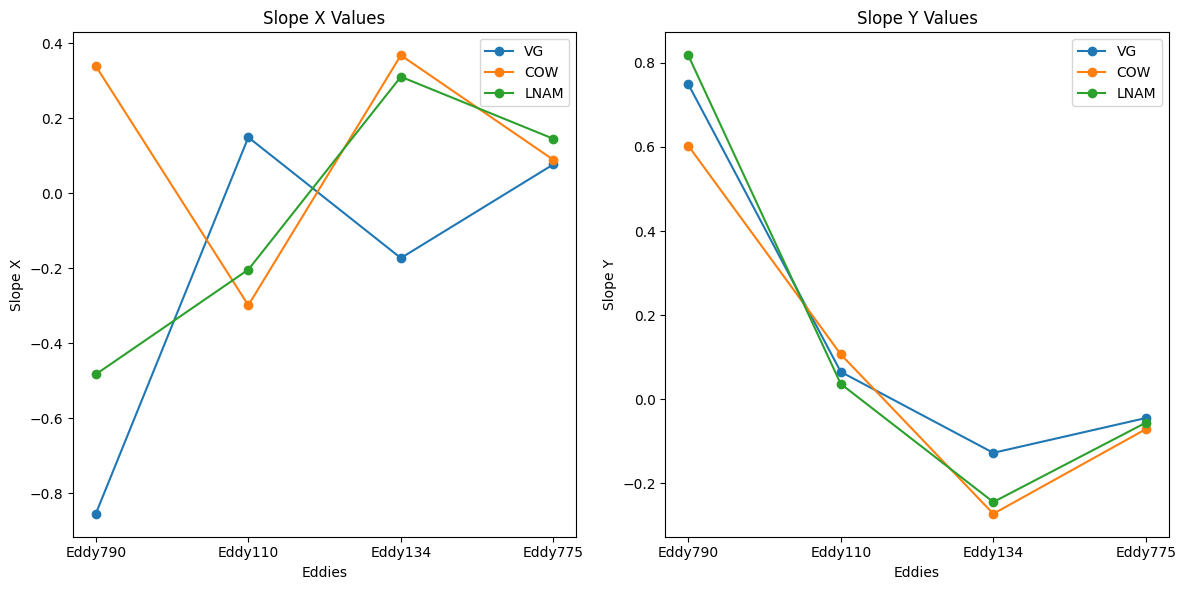

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels (assuming you have 4 eddies labeled accordingly)
eddies = the_frontier_eddies

# Convert slope values for plotting
def get_slope_values(slope_dic):
    return {key: [slope_dic[key][eddy] for eddy in eddies] for key in slope_dic.keys()}

slopex_values = get_slope_values(slopex_dic)
slopey_values = get_slope_values(slopey_dic)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x = np.arange(len(eddies))

# Plot slope x-values
for key, values in slopex_values.items():
    ax[0].plot(x, values, marker='o', label=key)
ax[0].set_title("Slope X Values")
ax[0].set_xticks(x)
ax[0].set_xticklabels([str(eddy) for eddy in eddies])
ax[0].legend()
ax[0].set_xlabel("Eddies")
ax[0].set_ylabel("Slope X")

# Plot slope y-values
for key, values in slopey_values.items():
    ax[1].plot(x, values, marker='o', label=key)
ax[1].set_title("Slope Y Values")
ax[1].set_xticks(x)
ax[1].set_xticklabels([str(eddy) for eddy in eddies])
ax[1].legend()
ax[1].set_xlabel("Eddies")
ax[1].set_ylabel("Slope Y")

plt.tight_layout()
plt.show()
